# Analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10
text_width_inches = 160 * 0.0393701  # Convert mm to inches (approx. 6.3 inches)
# Usage: figsize=(text_width_inches, fig_height)

pd.set_option("display.max_columns", None)

print(os.getcwd())
# Assert end of path is "analysis"
assert "analysis" in os.getcwd().split("/")[-1]
# os.chdir("analysis")

### Following, an unforunate hack to reach files at top-level for import
import sys

current = os.getcwd()  # In a notebook, this points to the notebook's directory
parent = os.path.dirname(current)
sys.path.append(parent)

/Users/jw/Documents/multi-imprinting/analysis


## Fetching, saving/loading, preprocessing, and checking data from wandb and locally stored json files

### Fetching from wandb and saving to df locally

Fetching ~950k runs took ~110min.

In [2]:
from datetime import datetime
from helper import fetch_data_from_wandb

start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")

# last_full_fetch = datetime(2024, 12, 4, 15)  # this took ~110min for ~950k runs
last_full_fetch_until = datetime(  # starting from earliest data possible
    2024, 12, 4, 15, 6, 35  # read out from previous file
)  # 2024-12-04_15:06:35
ignore_data_after = datetime(
    2024, 12, 5, 11, 20
)  # as explained above (-1h because of UTC)

# UNCOMMENT THE FOLLOWING IF YOU REALLY WANT TO FETCH DATA IN A CSV
# fetch_data_from_wandb(start_time, last_full_fetch_until, ignore_data_after)

### Gathering from local jsons and saving to df locally

To transmit all the thousands of .json files, create a tarball of all the results in the results folder on your PVC, and transfer that one.
I did this by running `tar -cvf /path/to/archive.tar /path/to/json-folder`.
(Sending the single files directly via kubectl would have probably taken much, much longer.)

I did *not* `gzip` it, because it is actually not super large (~300MB).

NOTE that maybe it would have been much faster simply compressing the results folder, or doing the below post-processing directly on the cluster, on the json files, and then only transfer the resulting CSV. Anyhow, this is one way to get the files.

In [3]:
from tqdm import tqdm
import tarfile

tar_file = "reprod"
tar_path = os.path.join("raw_results", "local_tarballs", tar_file + ".tar")

raw_json_results_dir = os.path.join("raw_results", "local_jsons", tar_file)

# Ensure the output directory exists
os.makedirs(raw_json_results_dir, exist_ok=True)

# SET THE FOLLOWING TO TRUE IF YOU REALLY WANT TO EXTRACT ALL THE DATA
extract_files = True

if extract_files:
    with tarfile.open(tar_path, "r") as tar:
        members = tar.getmembers()
        total_files = len(members)

        # Create a tqdm progress bar
        with tqdm(total=total_files, desc="Extracting files", unit="file") as pbar:
            for member in members:
                tar.extract(member, path=raw_json_results_dir)
                pbar.update(1)

Extracting files: 100%|██████████| 139939/139939 [00:21<00:00, 6399.13file/s]


In [4]:
from datetime import datetime
import os
import helper
import importlib

importlib.reload(helper)

ignore_data_before = datetime(1970, 1, 1)  # (cluster uses UTC)

tar_file = "reprod"
raw_json_results_dir_actual = os.path.join(
    "raw_results",
    "local_jsons",
    tar_file,
    tar_file,
)

# UNCOMMENT THE FOLLOWING IF YOU REALLY WANT TO GATHER DATA IN A CSV
helper.gather_data_from_jsons(raw_json_results_dir_actual, ignore_data_before)

Processing JSON files:   1%|          | 707/139938 [00:00<00:19, 7067.33it/s]

Gathering runs created at 2025-05-06 (0 runs checked, 0 runs gathered already


Processing JSON files:  30%|██▉       | 41458/139938 [00:03<00:08, 11338.61it/s]

Gathering runs created at 2025-05-20 (40000 runs checked, 40000 runs gathered already


Processing JSON files:  37%|███▋      | 51511/139938 [00:05<00:08, 10621.34it/s]

Gathering runs created at 2025-05-06 (50000 runs checked, 50000 runs gathered already


Processing JSON files:  65%|██████▌   | 91035/139938 [00:09<00:06, 8092.08it/s] 

Gathering runs created at 2025-05-20 (90000 runs checked, 90000 runs gathered already


Processing JSON files:  72%|███████▏  | 101267/139938 [00:10<00:05, 7557.05it/s]

Gathering runs created at 2025-05-06 (100000 runs checked, 100000 runs gathered already


Processing JSON files:  79%|███████▉  | 111217/139938 [00:12<00:03, 7401.82it/s]

Gathering runs created at 2025-05-20 (110000 runs checked, 110000 runs gathered already


Processing JSON files:  87%|████████▋ | 121053/139938 [00:13<00:02, 6729.68it/s]

Gathering runs created at 2025-05-06 (120000 runs checked, 120000 runs gathered already


Processing JSON files: 100%|██████████| 139938/139938 [00:16<00:00, 8446.54it/s]


Data saved to 139938runs_gathered_from_reprod_jsons.csv


### Dealing with all the fetched data

In [8]:
# wandb in raw_results/wandb_csvs
wandb_filenames = []
# json in raw_results/local_csvs
json_filenames = ["139938runs_gathered_from_reprod_jsons.csv"]

filepaths = [
    os.path.join("raw_results", "wandb_csvs", filename) for filename in wandb_filenames
] + [
    os.path.join("raw_results", "local_csvs", filename) for filename in json_filenames
]

df = pd.DataFrame()  # the final df
for filepath in filepaths:
    loaded_df = pd.read_csv(filepath)
    # Add origin column
    loaded_df["origin"] = filepath.split("from_")[-1].split(".")[0]

    # Concat dfs
    df = pd.concat([df, loaded_df])

df.reset_index(drop=True, inplace=True)
print(f"Total number of loaded runs: {len(df)}")

# Checked via sum(df["created_at"].isna()) == 0
if sum(df["created_at"].isna()) != 0:
    raise ValueError(
        "Some 'created_at' values are NaN! Should be impossible, "
        "because we made sure that all the data we imported above "
        "has this datum."
    )

# Remove duplicates (while ignoring 'created_at' column and keeping the first)
# Ensure 'created_at' is a datetime object
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d_%H:%M:%S")
# Sort by 'created_at' in ascending order and drop duplicates
df = df.sort_values(by="created_at", ascending=False).drop_duplicates(
    subset=df.columns.difference(["created_at"]), ignore_index=True
)
# df = df.drop_duplicates(ignore_index=True)

print(f"Total number of unique runs: {len(df)}")

df_loaded_state = df.copy()

df.head(3)

Total number of loaded runs: 139938
Total number of unique runs: 139938


,backbone_name,dataset_name,mapping_name,mapping,label_mapping_desc,task_name,task_splits,task_split,task_desc,normalize_input_data,normalize_for_proxy_selection,normalize_weights,presampling_method,presampling_quantiles_value,presampling_fewshot_value,proxy_method,k,aggregation_method,m,seed,task_acc,task_f1s,time_elapsed,created_at,origin
0,resnet50,ImageNet,map9-6,"{'677': 0, '694': 0, '403': 0, '130': 0, '639'...",677->0 & 694->0 & 403->0 & 130->0 & 639->0 & 6...,all,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9,l2,l2,l2,all,"[0, 1.0]",-1,kmeans,15,max,-1,12412312,85.755554,"{'remapped_class_index': [0, 1, 2, 3, 4, 5, 6,...",38.782108,2025-05-20 13:05:37,reprod_jsons
1,resnet50,ImageNet,map9-6,"{'677': 0, '694': 0, '403': 0, '130': 0, '639'...",677->0 & 694->0 & 403->0 & 130->0 & 639->0 & 6...,all,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9,l2,l2,l2,all,"[0, 1.0]",-1,kmeans,15,max,-1,123987,86.311111,"{'remapped_class_index': [0, 1, 2, 3, 4, 5, 6,...",55.888263,2025-05-20 13:04:58,reprod_jsons
2,resnet50,ImageNet,map10-8,"{'17': 0, '116': 0, '333': 0, '689': 0, '518':...",17->0 & 116->0 & 333->0 & 689->0 & 518->0 & 62...,all,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9,l2,l2,l2,all,"[0, 1.0]",-1,kmeans,15,max,-1,12412312,85.320000,"{'remapped_class_index': [0, 1, 2, 3, 4, 5, 6,...",39.718221,2025-05-20 13:04:09,reprod_jsons


#### Pre-processing and Saving

In [9]:
###
save_data_as_csv = True
origin = "reprod_jsons"
filename_desc = f"all_runs_{origin}"
###

import warnings
import ast
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

df = df_loaded_state[df_loaded_state["origin"] == origin].copy()

# Drop some columns that are redundant
df.drop(
    [
        "mapping",  # mapping_name is enough
        "label_mapping_desc",  # mapping_name is enough
        "task_splits",  # task_name is enough
        "task_split",  # task_name is enough
        "task_desc",  # task_name is enough
        "presampling_method",  # we are only doing "all"
        "presampling_quantiles_value",  # we are only doing "all"
        "task_f1s",  # not interested in it here
    ],
    axis=1,
    inplace=True,
)

# The num_proxies value can not be greater than selected few shots (or rather,
#  if that happened, then these runs are the same)
df.loc[
    (df["presampling_fewshot_value"] != -1)
    & (df["presampling_fewshot_value"] < df["k"]),
    "k",
] = df["presampling_fewshot_value"]


# NOTE that because of the usage of different devices, we can not really value
#  the time_elased.

print("Number of runs:", len(df))


acc_na_rows = df[df["task_acc"].isna()]
if not acc_na_rows.empty:
    print(f"{len(acc_na_rows)} runs with na task_acc:")
    print(acc_na_rows)
    print("Dropping them...")
    df = df.dropna(subset=["task_acc"])

# Count number of time nans (but keep them)
time_na_rows = df[df["time_elapsed"].isna()]
if not time_na_rows.empty:
    print(f"{len(time_na_rows)} runs with na time:")
    print(time_na_rows)
    print("Not dropping them!")
    # df = df.dropna(subset=["time"])

print(f"Total number of unique runs after pre-processing: {len(df)}")

# Save to CSV
if save_data_as_csv:
    # Find the earliest and latest created_at
    fromdatetime = df["created_at"].min().strftime("%Y-%m-%d_%H-%M-%S")
    todatetime = df["created_at"].max().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"preprocessed_results_{filename_desc}_{fromdatetime}-{todatetime}.csv"
    df.to_csv(
        os.path.join("combined_preprocessed_results", filename),
        index=False,
    )
    print(f"Data saved to '{filename}'.")

df_loaded = df

Number of runs: 139938
Total number of unique runs after pre-processing: 139938
Data saved to 'preprocessed_results_all_runs_reprod_jsons_2025-05-06_10-09-29-2025-05-20_13-05-37.csv'.


## Data analysis/science (start here if preprocessed CSV file already available)

### Load preprocessed data

In [49]:
df_loaded = pd.read_csv(
    os.path.join(
        "combined_preprocessed_results",
        "preprocessed_results_all_runs_reprod_jsons_2025-05-06_10-09-29-2025-05-20_13-05-37.csv",
    )
)
# "created_at" as datetime
df_loaded["created_at"] = pd.to_datetime(
    df_loaded["created_at"], format="%Y-%m-%d %H:%M:%S"
)
# Replace CIFAR10 by CIFAR-10
df_loaded["dataset_name"] = df_loaded["dataset_name"].replace({"CIFAR10": "CIFAR-10"})

### Compute ranks and their correlations

In [12]:
from copy import copy

# import importlib

import numpy as np
import pandas as pd
from prettytable import PrettyTable
from src.experiments.imagenet.prep import RANDOM_TASKS
from helper import GROUPPARAMS, HYPERPARAMS


# importlib.reload(helper)

tables_save_dict = "result_tables"
os.makedirs(tables_save_dict, exist_ok=True)

### SETUP
focus_column_values = {
    "backbone_name": ["resnet18", "vit_b_16"],
    "dataset_name": [
        # "ImageNet",
        "MNIST",
        "FashionMNIST",
        "CIFAR10",
    ],
    "seed": [17121997, 123987, 12412312],
    "task_name": [
        "all",
        "even",
        "odd",
        "short",
    ],
    # + [generate_task_desc([str(el) for el in rt[0]]) for rt in RANDOM_TASKS],
    "presampling_fewshot_value": [
        -1,
        # 1,
        # 2,
        # 5,
        # 10,
        # 20,
    ],
    "proxy_method": [
        # "all",  # for SAVEALL baseline
        # "random",  # for random selection baselin
        # "mean",  # Qi imprinting
        "kmeans",  # KMeans clustering
        # "kmedoids",  # KMedoids clustering
        # "fps",
        # "cov_max",
    ],
    "k": [
        # -1,
        # 1,
        # 2,
        # 3,
        # 5,
        # 10,
        20,
        # 100,
        # 200,
        # 500,
    ],  # 5, 10, 20],  # -1, 0, 100, 200, 500]
    "aggregation_method": [
        "mnn",
        "max",
    ],
    "m": [
        -1,
        1,
        3,
        5,
        20,
        50,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        # "none",
        "l2",
    ],
    "normalize_weights": [  # NORM_post for generated weights
        # "none",
        "l2",
        # "quantile",
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        # "none",
        "l2",
    ],
}
special_combinations = {
    # "Almost-Qi": {
    #     "normalize_for_proxy_selection": "none",
    #     "normalize_weights": "l2",
    #     "normalize_input_data": "l2",
    #     "proxy_method": "mean",
    #     "aggregation_method": "max",
    # },
    "Qi et al.": {
        "normalize_for_proxy_selection": "l2",
        "normalize_weights": "l2",
        "normalize_input_data": "l2",
        "proxy_method": "mean",
        "k": 1,
        "aggregation_method": "max",
        "m": -1,
    },
    "Hosoda et al.": {
        "normalize_for_proxy_selection": "none",
        "normalize_weights": "quantile",
        "normalize_input_data": "none",
        "proxy_method": "mean",
        "k": 1,
        "aggregation_method": "max",
        "m": -1,
    },
    "Jason et al.": {
        "normalize_for_proxy_selection": "none",
        "normalize_input_data": "none",
        "normalize_weights": "none",
        "proxy_method": "mean",
        "k": 1,
        "aggregation_method": "mnn",
        "m": 1,
    },
    # "(almost) iCarl": {
    #     "normalize_input_data": "none",
    #     "normalize_weights": "l2",  # Actually, should be none, but then we
    #     #  would have to actually compute |f(x)-prot| which involves |prot|;
    #     #  We don't have this! The closest we get is to use weight norm (even
    #     #  though iCarl doesn't do that step)
    #     "presampling_method": "all",
    #     "proxy_method": "mean",
    #     "aggregation_method": "max",
    # },
    "ours": {
        "normalize_for_proxy_selection": "l2",
        "normalize_weights": "l2",
        "normalize_input_data": "l2",
        "proxy_method": "kmeans",
        "k": 20,
        "aggregation_method": "max",
        "m": -1,
    },
}

highlight_hyperparams = {
    "SEL": [
        # "presampling_fewshot_value",
        "proxy_method",
        # "k",
    ],
    "NORM": [
        "normalize_input_data",
        "normalize_for_proxy_selection",
        "normalize_weights",
    ],
    "AGG": [
        "aggregation_method",
        "m",
    ],
    "special_combinations": [
        "Qi et al.",
        "Hosoda et al.",
        "Jason et al.",
        "ours",
    ],  # in that case, simply show the here defined sepcial combinations
    **{hp: [hp] for hp in HYPERPARAMS},
}
# This is a the components/combinations we highlight. That is, we show all combinations
#  for these, but only the best of all combinations amongst the
#  others (HYPERPARAMS-highlight_hyperparams[highlighter]).
highlighter = (
    "AGG"  # False, "AGG", "SEL", "NORM", "proxy_method", "special_combinations"
)
assert highlighter in highlight_hyperparams

focus_column_values_abbrevs = {
    "pres_few": "all",  # "little", "all"
    "proxy": "all",  # "mean,lmean",  # "standard",  # "standard",  # ="all,random,mean,n2mean,kmeans,kmed,agg,fps,cov",
    "num_proxies": "le20",  # "all",  # "large",  # "le5",  # "many", "le20"
    "agg": "max",  # "max", "mnn"
}

metrics = ["task_acc", "time_elapsed"]
ranking_metric_column = "task_acc"  # "task_acc" , "time_elapsed"
assert ranking_metric_column in metrics
metrics.remove(ranking_metric_column)

filename_prefix = (
    f"slice_{'_&_'.join(f'{k}_{v}' for k,v in focus_column_values_abbrevs.items())}"
)
filename_highlighter_suffix = f"highl_{highlighter}"
filename_metric_suffix = f"rked_by_{ranking_metric_column}"

In [13]:
from helper import draw_cd_diag_for_selected_runs

# Slice df
df_focus = df_loaded.copy()
for key, value in focus_column_values.items():
    df_focus = df_focus[df_focus[key].isin(value)]

# 1. Combine group and hyperparam columns (excluding seed)
df_seeds_aggregated = (
    df_focus.groupby(GROUPPARAMS + HYPERPARAMS)
    .agg(
        median_task_acc=(
            "task_acc",
            "median",
        ),  # Median task_acc across seeds
        count=("seed", "count"),
    )
    .reset_index()
)
num_seeds = len(focus_column_values["seed"])
if not all(df_seeds_aggregated["count"].unique() == num_seeds):
    print(
        f"WARN: There are not {num_seeds} runs in each group, even though we "
        f"have {num_seeds} seeds selected. This is unexpected."
    )
    amount1 = sum(df_seeds_aggregated["count"] == 1)
    percentage1 = 100 * amount1 / len(df_seeds_aggregated)
    amount2 = sum(df_seeds_aggregated["count"] == 2)
    percentage2 = 100 * amount2 / len(df_seeds_aggregated)
    print(f"Percentage of groups with 1 run: {percentage1:.2f}% ({amount1})")
    print(f"Percentage of groups with 2 runs: {percentage2:.2f}% ({amount2})")
ranked_data = []

# 2. Group by GROUPPARAMS for ranking
grouped = df_seeds_aggregated.groupby(GROUPPARAMS)
ranked_data = []

for group, group_df in grouped:
    group_df = group_df.copy()
    # Rank configurations within the group based on chosen (median) ranking metric
    #  (i.e., task_acc, time_elapsed)
    group_df["rank"] = group_df[f"median_{ranking_metric_column}"].rank(
        ascending=False
    )
    ranked_data.append(group_df)

# Combine all ranked data
ranked_df = pd.concat(ranked_data)

# 3.1 Compute the average rank, std, stderr, and average metric for each
#  unique configuration
aggregated = (
    ranked_df.groupby(HYPERPARAMS)
    .agg(
        avg_rank=("rank", "mean"),  # Average rank across groups
        std_rank=("rank", "std"),  # Standard deviation of ranks
        stderr_rank=(
            "rank",
            lambda x: np.std(x, ddof=1) / np.sqrt(len(x)),
        ),  # Standard error of ranks
        ##
        avg_task_acc=("median_task_acc", "mean"),  # Average task_acc across groups
        std_task_acc=("median_task_acc", "std"),  # Standard deviation of task_acc
        stderr_task_acc=(
            "median_task_acc",
            lambda x: np.std(x, ddof=1) / np.sqrt(len(x)),
        ),  # Standard error of task_acc
        count=("rank", "count"),  # Count of appearances in groups
    )
    .reset_index()
)

# Sort by average rank (ascending) to identify the best combinations
aggregated.sort_values(by="avg_rank", ascending=True, inplace=True)

# 3.2 Highlight the best combinations for the highlighter hyperparameters resp.
#  show only the special combinations (if highlighter is "special_combinations")
if highlighter == "special_combinations":
    highlight_combinations_keys = highlight_hyperparams[highlighter]
    # Can access the combinations via special_combinations[key] for key in
    #  highlight_combinations_keys
    # Group aggregated results by the hyperparameters that define special combinations
    keys = [
        "normalize_for_proxy_selection",
        "normalize_input_data",
        "normalize_weights",
        "proxy_method",
        "k",
        "aggregation_method",
        "m",
    ]
    aggregated_groups = aggregated.groupby(keys, sort=False)
    # Clear it to fill it with special combinations
    aggregated = aggregated.iloc[:0]
    for key in highlight_combinations_keys:
        special_combination = special_combinations[key]
        # Check which group the special combination belongs to, i.e., find
        #  the first group that the combination falls into
        # Loop over all the group combinations
        fitting_group_key = None

        for group_key in aggregated_groups.groups.keys():
            if not isinstance(group_key, tuple):
                group_dict = {aggregated_groups.keys[0]: group_key}
            else:
                group_dict = dict(zip(keys, group_key))
            # Check if special combination matches this group
            if all(
                special_combination[param] == group_dict[param]
                for param in special_combination.keys()
            ):
                fitting_group_key = group_key
                break
        assert fitting_group_key is not None, print(
            f"Special combination {key} does not fit into any group."
        )
        # Get all runs within the group we identified and find matching combination
        group = aggregated_groups.get_group(fitting_group_key)
        found_special_combination = group.loc[
            (group[list(special_combination)] == pd.Series(special_combination)).all(
                axis=1
            )
        ]
        assert (
            len(found_special_combination) > 0
        ), f"Special combination {key} not found."
        # Take the best one with regards to avg rank
        found_special_combination = (
            pd.DataFrame(
                found_special_combination.loc[
                    found_special_combination["avg_rank"].idxmin()
                ]
            )
            .copy()
            .T
        )
        found_special_combination.loc[:, "WHAT?"] = key

        # Insert it into aggregated
        aggregated = pd.concat(
            [aggregated, found_special_combination.reset_index(drop=True)]
        ).reset_index(drop=True)
    highlight_combinations_keys = []  # because as keys, they are not useful later

elif highlighter is not False:
    highlight_combinations_keys = highlight_hyperparams[highlighter]
    # Find the best rows for the highlighted hyperparameters
    aggregated_groups = aggregated.groupby(highlight_combinations_keys, sort=False)

    best_combinations = aggregated_groups.first().reset_index()
    best_combinations["WHAT?"] = "BEST IN GROUP"

    # Concatenate the best combinations and baseline
    aggregated = best_combinations.reset_index(drop=True)

# 3.3 Pretty print "aggregated" to console, png, and tex code
vis_hyperparams = copy(HYPERPARAMS)

# Round "avg_rank", f"avg_{ranking_metric_column}" to 2 decimal places
aggregated["avg_rank"] = aggregated["avg_rank"].astype(float).round(2)
aggregated[f"avg_{ranking_metric_column}"] = (
    aggregated[f"avg_{ranking_metric_column}"].astype(float).round(2)
)

# Hide some columns
ignore_columns_in_table = [
    "presampling_fewshot_value",
]
if "mnn" not in focus_column_values["aggregation_method"]:
    ignore_columns_in_table.append("m")
for key in ignore_columns_in_table:
    vis_hyperparams.remove(key)

# Hide more in Tex table
ignore_columns_in_tex_table = ignore_columns_in_table + [
    "normalize_input_data",
    "normalize_for_proxy_selection",
    "normalize_layer_activations",
    "normalize_weights",
    "presampling_method",
    "presampling_quantile",
    "avg_rank",
]

# Hide rows
ignore_rows_in_table = ["MEDIAN IN GROUP", "OVERALL BEST"]
ignore_rows_in_tex_table = ignore_rows_in_table + []
# ignore_rows_in_cd_diag = ignore_rows_in_table + []

table = PrettyTable()
table.field_names = [
    "WHAT?",
    *highlight_combinations_keys,
    "-",  # Separator
    "Avg Rank",
    # "Rank Std",
    # "Rank Stderr",
    f"Avg {ranking_metric_column}",
    # f"{ranking_metric_column} Std",
    # f"{ranking_metric_column} Stderr",
    # f"Avg {metrics[0]}",
    # f"{metrics[0]} Std",
    # f"{metrics[0]} Stderr",
    # f"Avg {metrics[1]}",
    # f"{metrics[1]} Std",
    # f"{metrics[1]} Stderr",
    *[hp for hp in vis_hyperparams if hp not in highlight_combinations_keys],
    # "Count",
]

for _, row in aggregated.iterrows():
    if row["WHAT?"] == "BEST IN GROUP":
        table.add_row(["-"] * len(table.field_names))
    if row["WHAT?"] == "OVERALL BEST" and "OVERALL BEST" in ignore_rows_in_table:
        continue
    table.add_row(
        [
            row["WHAT?"],
            *[row[param] for param in highlight_combinations_keys],
            "-",
            f"{row['avg_rank']:.2f}",
            # f"{row['std_rank']:.2f}",
            # f"{row['stderr_rank']:.2f}",
            f"{row[f'avg_{ranking_metric_column}']:.2f}",
            # f"{row[f'std_{ranking_metric_column}']:.2f}",
            # f"{row[f'stderr_{ranking_metric_column}']:.2f}",
            *[
                row[param]
                for param in vis_hyperparams
                if param not in highlight_combinations_keys
            ],
            # row["count"],
        ]
    )

print(
    f"Best HP combs across groups {GROUPPARAMS}, "
    f"highlighted along HPs {highlight_combinations_keys}:"
)
print(table)
# Save table to txt (pretty) and csv file
with open(
    os.path.join(
        tables_save_dict,
        f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.txt",
    ),
    "w",
) as f:
    f.write(str(table))
aggregated.to_csv(
    os.path.join(
        tables_save_dict,
        f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.csv",
    ),
    index=False,
)
# Also, save as image for "nice" (rather: ad hoc) share format
from PIL import Image, ImageDraw  # , ImageFont

im = Image.new("RGB", (3250, 100 + 20 * (len(aggregated) - 1)), "white")
draw = ImageDraw.Draw(im)
# font = ImageFont.truetype("FreeMono.ttf", 15)
draw.text((10, 10), str(table), fill="black")
# im.show()
im.save(
    os.path.join(
        tables_save_dict,
        f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.png",
    )
)

# Also save as Tex file
col_slice = (
    ["WHAT?"]
    + highlight_combinations_keys
    + ["avg_rank", f"avg_{ranking_metric_column}", f"avg_{metrics[0]}", "count"]
    + [param for param in vis_hyperparams if param not in highlight_combinations_keys]
)
tex_table = aggregated[
    [
        col
        for col in col_slice
        if col in aggregated.columns and col not in ignore_columns_in_tex_table
    ]
]
tex_table = tex_table[~tex_table["WHAT?"].isin(ignore_rows_in_tex_table)]
# Adjust some column names for paper
tex_table = tex_table.rename(
    columns={
        "WHAT?": "Description",
        "num_proxies": "$k$",
        "avg_rank": "Avg. Rank",
        f"avg_{ranking_metric_column}": f"Avg. {ranking_metric_column}",
        f"avg_{metrics[0]}": f"Avg. {metrics[0]}",
        "count": "Count",
        "proxy_method": "Proxy Method",
        "aggregation_method": "\AGG",  # TODO: add l-number in here
    }
)
# Ignore them and convert to tex table
tex_table.rename(columns=lambda x: x.replace("_", " ")).style.hide(
    axis="index"
).format(precision=2).to_latex(
    os.path.join(
        tables_save_dict,
        f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.tex",
    ),
)

# Get CD diagram for aggregated
metric = "median_task_acc"  # i.e., "Accuracy" will come from "median_task_acc"
draw_cd_diag_for_selected_runs(
    aggregated,
    df_seeds_aggregated,
    highlight_combinations_keys,
    metric,
    filename_prefix,
    f"{filename_highlighter_suffix}_{filename_metric_suffix}",
)

Best HP combs across groups ['backbone_name', 'dataset_name', 'mapping_name', 'task_name'], highlighted along HPs ['aggregation_method', 'm']:
+---------------+--------------------+----+---+----------+--------------+-------------------------------+-------------------+----------------------+--------------+----+
|     WHAT?     | aggregation_method | m  | - | Avg Rank | Avg task_acc | normalize_for_proxy_selection | normalize_weights | normalize_input_data | proxy_method | k  |
+---------------+--------------------+----+---+----------+--------------+-------------------------------+-------------------+----------------------+--------------+----+
|       -       |         -          | -  | - |    -     |      -       |               -               |         -         |          -           |      -       | -  |
| BEST IN GROUP |        max         | -1 | - |   1.58   |    91.48     |               l2              |         l2        |          l2          |    kmeans    | 20 |
|       -   

### Line chart for accuracy over number of proxies k (Figure 6)

In [107]:
graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)


### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        # "vit_b_16",
    ],
    "dataset_name": [
        # "ImageNet",
        # "MNIST",
        # "FashionMNIST",
        "CIFAR10",
    ],
    "seed": [17121997, 123987, 12412312],
    "task_name": [
        "all",
        # "even",
        # "odd",
        # "short",
    ],
    # + [generate_task_desc([str(el) for el in rt[0]]) for rt in RANDOM_TASKS],
    "presampling_fewshot_value": [
        -1,
        # 1,
        # 2,
        # 5,
        # 10,
        # 20,
    ],
    "proxy_method": [
        "kmeans",
        "kmedoids",
        "mean",
        "cov_max",
        "random",
        "fps",
        "all",
    ],
    "k": [
        -1,
        1,
        2,
        3,
        5,
        10,
        20,
        50,
        100,
    ],
    "aggregation_method": [
        "max",
    ],
    "m": [
        -1,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        "l2",
    ],
    "normalize_weights": [  # NORM_post for generated weights
        "l2",
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        "l2",
    ],
}

focus_column_values_abbrevs = {
    "bb": "res",
    "ds": "cif",
    "task": "long",
    "map": "none",
    "pres_few": "all",  # "little", "all"
    "proxy": "standard",  # "mean,lmean",  # "standard",  # "standard",  # ="all,random,mean,n2mean,kmeans,kmed,agg,fps,cov",
    "num_proxies": "large",  # "all",  # "large",  # "verysmall",  # "many", "small"
    "agg": "max",  # "mean,max,knn",
}

plotting_metric_column = (
    "task_acc"  # "task_acc" , "time", # TODO: task_f1_weighted_avg
)
filename_prefix = (
    f"slice_{'_&_'.join(f'{k}_{v}' for k,v in focus_column_values_abbrevs.items())}"
)

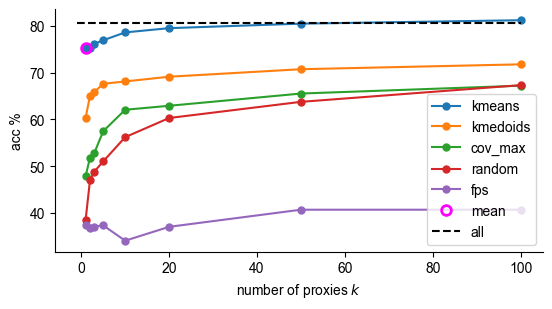

In [112]:
%matplotlib inline
from copy import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import GROUPPARAMS, HYPERPARAMS

df_focus = df_loaded.copy()
for key, value in focus_column_values.items():
	df_focus = df_focus[df_focus[key].isin(value)]

df_focus = (
	df_focus
	.groupby(GROUPPARAMS + HYPERPARAMS)
	.agg(
		avg_task_acc=("task_acc", "median"),
		count=("seed", "count"),
	)
	.reset_index()
)
df_focus.sort_values(GROUPPARAMS, inplace=True)

backbones     = df_focus["backbone_name"].unique()
datasets      = df_focus["dataset_name"].unique()
mapping_names = df_focus["mapping_name"].unique()
task_names    = df_focus["task_name"].unique()

nrows = len(backbones)
ncols = len(datasets) * len(mapping_names) * len(task_names)
aspect_ratio = 2 / 4
fig_height   = text_width_inches * aspect_ratio

if nrows > 1 or ncols > 1:
	fig, axes = plt.subplots(
		nrows=nrows,
		ncols=ncols,
		figsize=(3 * text_width_inches, 3 * fig_height),
		sharex=True,
		sharey=True
	)
else:
	fig  = plt.figure(figsize=(text_width_inches, fig_height))
	axes = [[fig.add_subplot(1, 1, 1)]]

for i, backbone_name in enumerate(backbones):
	per_row_counter = 0
	for dataset_name in datasets:
		for task_name in task_names:
			for mapping_name in mapping_names:
				ax = axes[i][per_row_counter]
				per_row_counter += 1

				sliced = df_focus[
					(df_focus["backbone_name"] == backbone_name) &
					(df_focus["dataset_name"]  == dataset_name)  &
					(df_focus["task_name"]     == task_name)     &
					(df_focus["mapping_name"]  == mapping_name)
				]

				df_vis = []
				for proxy_method in focus_column_values["proxy_method"]:
					proxy_df = sliced[sliced["proxy_method"] == proxy_method].copy()
					proxy_df["key"] = proxy_method
					df_vis.append(proxy_df)
				# for key, combination in special_combinations.items():
				#     special_df = sliced[
				#         (sliced[list(combination)] == pd.Series(combination)).all(axis=1)
				#     ].copy()
				#     special_df["key"] = key
				#     df_vis.append(special_df)
				df_vis = pd.concat(df_vis, ignore_index=True)

				df_vis_piv = df_vis.pivot(index="k", columns="key", values="avg_task_acc")
				df_vis_piv.ffill(inplace=True)
				df_vis_piv = df_vis_piv[df_vis_piv.index <= 100]

				df_vis_piv_not_all = df_vis_piv.drop(columns=["all"], errors="ignore")
				df_vis_piv_not_all = df_vis_piv_not_all.loc[df_vis_piv_not_all.index != -1]
				if "mean" in df_vis_piv_not_all.columns:
					df_vis_piv_not_all = df_vis_piv_not_all.drop(columns=["mean"])
				order = df_vis_piv_not_all.loc[5].sort_values(ascending=False).index.tolist()
				df_vis_piv_not_all = df_vis_piv_not_all[order]

				styles = ['-o'] * df_vis_piv_not_all.shape[1]
				df_vis_piv_not_all.plot(ax=ax, style=styles, linewidth=1.5, markersize=5, legend=False)

				if 1 in df_vis_piv.index and "mean" in df_vis_piv.columns:
					mean_val = df_vis_piv.at[1, "mean"]
					ax.plot(1, mean_val,
							linestyle="None",
							marker="o",
							markersize=7,
							markerfacecolor="none",      # make center transparent
							markeredgecolor="magenta",
							markeredgewidth=2,
							label="mean")

				df_vis_piv["all"].plot(ax=ax, linestyle="--", linewidth=1.5, color="black", label="all")

				ax.legend(loc="lower right")
				ax.set_xlabel(r"number of proxies $k$")
				if i == 0:
					ax.set_ylabel("acc %")
				# ax.set_title(f"{backbone_name}, {dataset_name}, {task_name}, {mapping_name}")
				ax.spines['top'].set_visible(False)
				ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig(os.path.join(graphs_save_dict, f"{filename_prefix}_k_vs_avg_acc.pdf"), bbox_inches="tight", dpi=300)
plt.show()

### Few-Shot line splots (Figure 10)

In [16]:
graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)


### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        "vit_b_16",
    ],
    "dataset_name": [
        "MNIST",
        "FashionMNIST",
        "CIFAR10",
    ],
    "seed": [14057, 994348, 23092007, 123456, 98765],
    "task_name": [
        "all",
    ],
    "presampling_fewshot_value": [
        -1,
        1,
        2,
        5,
        10,
        20,
        50,
        100,
        200,
        400,
        600,
        800,
        1000,
    ],
    "proxy_method": [
        "kmeans",
        # "all",
    ],
    "k": [
        -1,
        1,
        5,
        20,
    ],
    "aggregation_method": [
        "max",
    ],
    "m": [
        -1,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        "l2",
    ],
    "normalize_weights": [  # NORM_post for generated weights
        "l2",
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        "l2",
    ],
}

focus_column_values_abbrevs = {
    "bb": "all",
    "ds": "all",
    "task": "long",
    "map": "none",
    "pres_few": "all",  # "little", "all"
    "proxy": "kmeans",  # "mean,lmean",  # "standard",  # "standard",  # ="all,random,mean,n2mean,kmeans,kmed,agg,fps,cov",
    "num_proxies": "standard",  # "all",  # "large",  # "verysmall",  # "many", "small"
    "agg": "max",  # "mean,max,knn",
}

plotting_metric_column = "task_acc"
filename_prefix = (
    f"slice_{'_&_'.join(f'{k}_{v}' for k,v in focus_column_values_abbrevs.items())}"
)

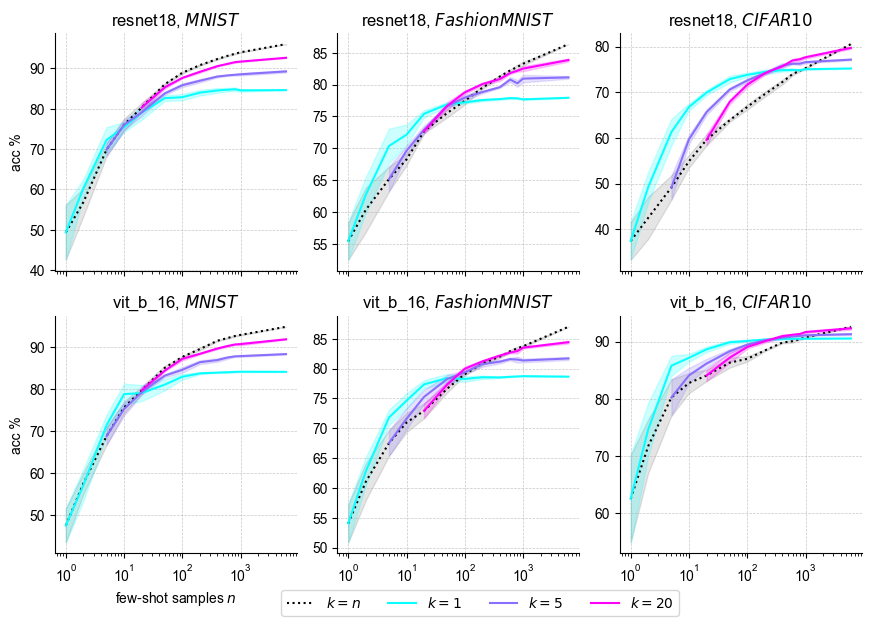

In [194]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import GROUPPARAMS, HYPERPARAMS

# filter and aggregate
df_focus = df_loaded.copy()
for key, vals in focus_column_values.items():
    df_focus = df_focus[df_focus[key].isin(vals)]

df_focus = (
    df_focus
    .groupby(GROUPPARAMS + HYPERPARAMS)
    .agg(
        mean_task_acc=("task_acc", "median"),
        std=("task_acc", "std"),
        count=("seed", "count"),
    )
    .reset_index()
)
df_focus.sort_values(GROUPPARAMS, inplace=True)
df_focus["lower_ci"] = df_focus["mean_task_acc"] - 1.96 * (df_focus["std"] / np.sqrt(df_focus["count"]))
df_focus["upper_ci"] = df_focus["mean_task_acc"] + 1.96 * (df_focus["std"] / np.sqrt(df_focus["count"]))

backbones   = df_focus["backbone_name"].unique()
datasets    = df_focus["dataset_name"].unique()
# Sort like MNIST, FashionMNIST, CIFAR10 (if existing)
datasets = sorted(datasets, key=lambda x: (x != "MNIST", x != "FashionMNIST", x != "CIFAR10"))
mapping     = "kmeans"
task        = "all"
k_vals      = sorted([k for k in df_focus["k"].unique() if k <= focus_column_values["presampling_fewshot_value"][-1]])
colors = {
    -1: "black",
     1: np.array([9,255,255]) / 255,
     5: np.array([137,111,251]) / 255,
    20: np.array([255,0,250])   / 255,
}
linestyles  = { -1: ":", 1: "-", 5: "-", 20: "-" }

nrows, ncols = len(backbones), len(datasets)
aspect_ratio = 3 / 4
fig_height   = text_width_inches * aspect_ratio
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
	figsize=(1.4*text_width_inches, 1.4*fig_height),
    sharex=True,
    sharey=False
)

# ensure axes is 2D array
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = np.array([axes])
elif ncols == 1:
    axes = np.array([[ax] for ax in axes])

for i, bb in enumerate(backbones):
    for j, ds in enumerate(datasets):
        ax = axes[i, j]
        for k in k_vals:
            subset = df_focus[
                (df_focus["backbone_name"] == bb) &
                (df_focus["dataset_name"]  == ds) &
                (df_focus["proxy_method"]  == mapping) &
                (df_focus["task_name"]     == task) &
                (df_focus["k"]             == k)
            ].copy()
            if subset.empty:
                continue
            # Replace -1 fewshot_value by 6000
            subset["presampling_fewshot_value"] = subset["presampling_fewshot_value"].replace(-1, 6000)
            if k != -1:
                subset = subset[subset["k"] <= subset["presampling_fewshot_value"]]
            if subset.empty:
                continue

			# Sort by presampling fewshot_value
            subset = subset.sort_values("presampling_fewshot_value")

            ax.plot(
                subset["presampling_fewshot_value"],
                subset["mean_task_acc"],
                linestyle=linestyles[k],
                color=colors[k],
                label=r"$k=n$" if k == -1 else rf"$k={k}$"
            )
            alpha = 0.2 if k != -1 else 0.1
            ax.fill_between(
                subset["presampling_fewshot_value"],
                subset["lower_ci"],
                subset["upper_ci"],
                color=colors[k],
                alpha=alpha,
            )

        ax.set_xscale("log")
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        ax.set_title(rf"{bb}, ${ds}$")
        if i == nrows - 1 and j==0:
            ax.set_xlabel(r"few-shot samples $n$")
        if j == 0:
            ax.set_ylabel("acc %")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels, loc="lower center", ncol=len(k_vals),
           bbox_to_anchor=(0.55, 0.05),
           )
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    os.path.join(graphs_save_dict, f"k_vs_n_logscale_Qi.pdf"),
    bbox_inches="tight",
    dpi=300
)
plt.show()

### NC Line and Dot Plots (Figure 11)

In [104]:
# Get NC results from nc_results/imagenet_nc1_results.csv and standard_nc1_results.csv
nc1_results = pd.read_csv(os.path.join("nc_results", "imagenet_nc1_results.csv"))
# Concat other results
standard_nc1_results = pd.read_csv(
    os.path.join("nc_results", "standard_nc1_results.csv")
)
nc1_results = pd.concat([nc1_results, standard_nc1_results], ignore_index=True)
nc1_results

,dataset,backbone,remapping,n_classes_per_label,remapping_index,nc_1
0,ImageNet,resnet18,1_in_1-0,1.0,0.0,0.249113
1,ImageNet,resnet18,1_in_1-1,1.0,1.0,0.549280
2,ImageNet,resnet18,1_in_1-2,1.0,2.0,0.531872
3,ImageNet,resnet18,1_in_1-3,1.0,3.0,0.231757
4,ImageNet,resnet18,1_in_1-4,1.0,4.0,0.359873
...,...,...,...,...,...,...
407,FashionMNIST,vit_b_16,NaN,NaN,NaN,1.954377
408,CIFAR10,vit_b_16,NaN,NaN,NaN,0.427542
409,MNIST,swin_b,NaN,NaN,NaN,7.510301
410,FashionMNIST,swin_b,NaN,NaN,NaN,2.043176


/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_19725/2354586041.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other["dataset"] = other["dataset"].replace("CIFAR10", "CIFAR-10")


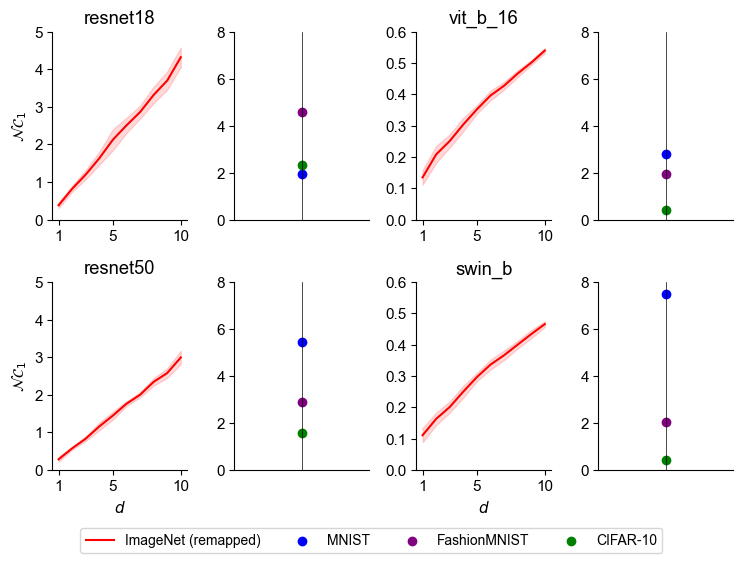

In [106]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load data
nc1_results = pd.read_csv(os.path.join("nc_results", "imagenet_nc1_results.csv"))
standard_nc1 = pd.read_csv(os.path.join("nc_results", "standard_nc1_results.csv"))
nc1_results = pd.concat([nc1_results, standard_nc1], ignore_index=True)

results_all = nc1_results[nc1_results["dataset"] == "ImageNet"]
other = nc1_results[nc1_results["dataset"] != "ImageNet"]

backbone = ["resnet18", "vit_b_16", "resnet50", "swin_b"]
aspect_ratio = 3 / 4
fig_height = text_width_inches * aspect_ratio

plt.rcParams.update({"font.size": 11})  # Adjust size as needed
fig, ax = plt.subplots(
    2,
    4,
    figsize=(1.2 * text_width_inches, 1.2 * fig_height),
)
count_lm = -1
count_d = -1

# Rename CIFAR10 to CIFAR-10
other["dataset"] = other["dataset"].replace("CIFAR10", "CIFAR-10")

for i in range(2):
    for j in range(4):
        if j % 2 == 0:  # ImageNet
            count_lm += 1
            bb = backbone[count_lm]
            df_bb = results_all[results_all["backbone"] == bb]
            d_vals = np.sort(df_bb["n_classes_per_label"].dropna().unique())

            mean_values = []
            ci_lower = []
            ci_upper = []
            for d in d_vals:
                arr = df_bb[df_bb["n_classes_per_label"] == d]["nc_1"]
                m = arr.mean()
                std = arr.std()
                n = arr.count()
                mean_values.append(m)
                ci_lower.append(m - 1.96 * (std / np.sqrt(n)))
                ci_upper.append(m + 1.96 * (std / np.sqrt(n)))

            ax[i, j].plot(
                d_vals, mean_values, "-", color="red", label="ImageNet (remapped)"
            )
            ax[i, j].fill_between(d_vals, ci_lower, ci_upper, color="red", alpha=0.15)
            ax[i, j].spines["right"].set_visible(False)
            ax[i, j].spines["top"].set_visible(False)
            ax[i, j].set_title(bb)
            ax[i, j].set_xticks(d_vals)

            if bb in ["resnet18", "resnet50"]:
                ax[i, j].set_ylabel(r"$\mathcal{NC}_1$")
            if bb in ["resnet50", "swin_b"]:
                ax[i, j].set_xlabel("$d$")

            # y-axis scaling
            if bb in ["resnet18", "resnet50"]:
                ax[i, j].set_ylim(0, 5)
            elif bb in ["vit_b_16", "swin_b"]:
                ax[i, j].set_ylim(0, 0.6)

            # adjust x-ticks
            ax[i, j].set_xticks([1, 5, 10])
            ax[i, j].set_xticklabels(["1", "5", "10"])

        else:  # Other datasets
            count_d += 1
            bb = backbone[count_d]
            df_bb = results_all[results_all["backbone"] == bb]
            other_bb = other[other["backbone"] == bb]

            d_max = np.max(df_bb["n_classes_per_label"].dropna())
            ax[i, j].axvline(d_max, color="black", linewidth=0.5)

            colors = ["blue", "purple", "green"]
            datasets = ["MNIST", "FashionMNIST", "CIFAR-10"]
            for k, ds in enumerate(datasets):
                y = other_bb[other_bb["dataset"] == ds]["nc_1"].values
                if y.size:
                    ax[i, j].scatter(d_max, y[0], color=colors[k], label=ds)

            ax[i, j].spines["right"].set_visible(False)
            ax[i, j].spines["top"].set_visible(False)
            ax[i, j].set_xticks([])
            ax[i, j].set_ylim(0, 8)

h1, l1 = ax[0, 0].get_legend_handles_labels()  # the ImageNet line
h2, l2 = ax[1, 1].get_legend_handles_labels()  # the MNIST/Fashion/CIFAR dots
fig.legend(
    h1 + h2, l1 + l2, loc="lower center", ncol=4, bbox_to_anchor=(0.5, 0), fontsize=10
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(os.path.join(graphs_save_dict, f"nc1.pdf"), bbox_inches="tight", dpi=300)
plt.show()

### NC and Num Proxies (Figure 12)

In [ ]:
graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)

### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        "resnet50",
        "swin_b",
        "vit_b_16",
    ],
    "dataset_name": [
        "ImageNet",
        "MNIST",
        "FashionMNIST",
        "CIFAR-10",
    ],
    "seed": [17121997, 123987, 12412312],
    "mapping_name": [
        "none",
        # map1-0, ..., map1-9, map2-0, ..., map2-9, ..., map10-0, ..., map10-9
        *[f"map{i}-{j}" for i in range(1, 11) for j in range(10)],
    ],
    "task_name": [
        "all",
    ],
    "presampling_fewshot_value": [
        -1,
    ],
    "proxy_method": [
        "kmeans",
    ],
    "k": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "aggregation_method": [
        "max",
    ],
    "m": [
        -1,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        # "l2",  # Qi
        "none",  # almost Qi
    ],
    "normalize_weights": [  # NORM_post for generated weights
        "l2",
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        "l2",
    ],
}

/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_19725/2010373897.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_im["d"] = df_im["mapping_name"].str.extract(r"map(\d+)-")[0].astype(int)


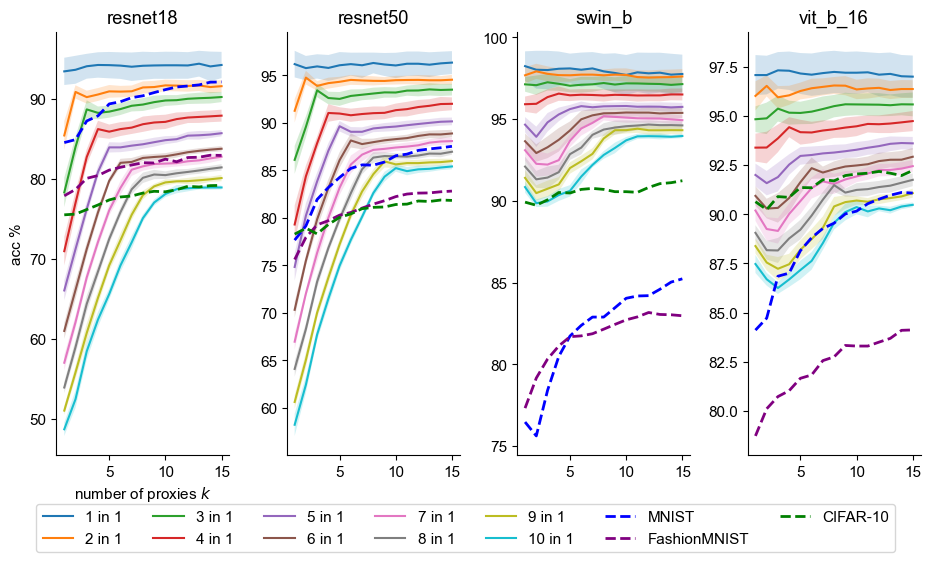

In [110]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import GROUPPARAMS, HYPERPARAMS

# filter and aggregate
df_focus = df_loaded.copy()
for key, vals in focus_column_values.items():
	df_focus = df_focus[df_focus[key].isin(vals)]

df_focus = (
	df_focus
	.groupby(GROUPPARAMS + HYPERPARAMS)
	.agg(
		median_task_acc=("task_acc", "median"),
		std=("task_acc", "std"),
		count=("seed", "count"),
	)
	.reset_index()
)
df_focus.sort_values(GROUPPARAMS, inplace=True)

df_focus = df_focus[[
	"backbone_name",
	"dataset_name",
	"mapping_name",
	"k",
	"median_task_acc",
]]



# ImageNet: aggregate over 10 remappings for each d
df_im = df_focus[df_focus["dataset_name"] == "ImageNet"]
# extract d from mapping_name for ImageNet
df_im["d"] = df_im["mapping_name"].str.extract(r"map(\d+)-")[0].astype(int)
df_im_agg = (
	df_im
	.groupby(["backbone_name","k","d"])
	.agg(
		mean_acc=("median_task_acc","mean"),
		std_acc=("median_task_acc","std"),
		count=("median_task_acc","count"),
	)
	.reset_index()
)
df_im_agg["ci95"] = 1.96 * df_im_agg["std_acc"] / np.sqrt(df_im_agg["count"])


# small datasets: use df_focus directly
small = ["MNIST", "FashionMNIST", "CIFAR-10"]
colors = {"MNIST": "blue", "FashionMNIST": "purple", "CIFAR-10": "green"}
linestyles = {"MNIST": "--", "FashionMNIST": "--", "CIFAR-10": "--"}
backbones = ["resnet18", "resnet50", "swin_b", "vit_b_16"]


aspect_ratio = 3 / 4
fig_height = text_width_inches * aspect_ratio
# Increase font size because of larger figure
plt.rcParams.update({'font.size': 11})  # Adjust size as needed
fig, axes = plt.subplots(1, 4, sharey=False, figsize=(1.5*text_width_inches, 1.2*fig_height))


for ax, bb in zip(axes, backbones):
	# ImageNet remappings
	for d in sorted(df_im_agg["d"].unique()):
		ddf = df_im_agg[(df_im_agg["backbone_name"] == bb) & (df_im_agg["d"] == d)].sort_values("k")
		ax.plot(ddf["k"], ddf["mean_acc"], label=f"{d} in 1")
		ax.fill_between(
			ddf["k"],
			ddf["mean_acc"] - ddf["ci95"],
			ddf["mean_acc"] + ddf["ci95"],
			alpha=0.2,
		)
	# small datasets
	for ds in small:
		sdf = df_focus[(df_focus["backbone_name"] == bb) & (df_focus["dataset_name"] == ds)].sort_values("k")
		ax.plot(
			sdf["k"],
			sdf["median_task_acc"],
			color=colors[ds],
			linestyle=linestyles[ds],
			label=ds,
			linewidth=2,
		)

	ax.set_title(bb)
	ax.spines["top"].set_visible(False)
	ax.spines["right"].set_visible(False)

axes[0].set_xlabel(r"number of proxies $k$")
axes[0].set_ylabel("acc %")

h1, l1 = ax.get_legend_handles_labels()
fig.legend(
    h1, l1, loc="lower center", ncol=7, bbox_to_anchor=(0.5, 0), fontsize=11
)
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig(
	os.path.join(graphs_save_dict, f"var_num_proxies_vs_datasets_almost_Qi.pdf"),
	bbox_inches="tight",
	dpi=300
)
plt.show()
